# 04 model building - ALL spots

**Objectives:**
* Using the filtered feature subset, train a GBM model that predicts the AB1_StdDev_Yen variable
* Use the model as input for computing partial dependence plots
* Use the model as input for Anchors / LIME explanations

In [1]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

sns.set(style="whitegrid")

In [2]:
boruta_ex7_genes = [
    '2810433D01Rik', 'Apoe', 'B2m', 'C1qa', 'C1qb', 'C1qc', 'C3ar1', 'C4a',
    'C4b', 'Ccl3', 'Ccl6', 'Cd14', 'Cd52', 'Cd68', 'Cd74', 'Cd9', 'Clec7a',
    'Clu', 'Csf1r', 'Cst3', 'Cst7', 'Ctsb', 'Ctsd', 'Ctsl', 'Ctss', 'Ctsz',
    'Cxcl5', 'Fcer1g', 'Fcgr2b', 'Fcgr3', 'Fcrls', 'Fth1', 'Gfap',
    'Gm28437', 'Gm7079', 'Gpnmb', 'Grn', 'H2-Aa', 'H2-D1', 'Hexa', 'Hexb',
    'Irf8', 'Itgax', 'Itgb5', 'Kif15', 'Lag3', 'Laptm5', 'Lgals3bp',
    'Lrrc17', 'Ly86', 'Lyz1', 'Lyz2', 'Mamdc2', 'Mpeg1', 'Olfml3',
    'Olfr912', 'Plek', 'Rplp1', 'Rps12', 'Serpina3n', 'Sez6', 'Slc6a3',
    'Spp1', 'Trem2', 'Tyrobp', 'Wfdc17', 'mt-Rnr1', 'mt-Rnr2']

In [32]:
pd.DataFrame(boruta_ex7_genes).to_csv('ex7.txt', index=None, header=None)

---

### Load the data

In [3]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [4]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 111 ms, sys: 271 ms, total: 382 ms
Wall time: 189 ms


In [5]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 15.4 s, sys: 6.47 s, total: 21.9 s
Wall time: 21.9 s


In [6]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [7]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT'] = st_df['GT'].astype('category', copy=False)
st_df['age'] = st_df['age_GT'].astype('category', copy=False)
st_df['age_GT'] = st_df['age_GT'].astype('category', copy=False)

In [8]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

In [9]:
expression_df = st_df[gene_columns]

In [10]:
assert expression_df.shape == (10327, 46454)

---

# Build a GBM model

* https://stats.stackexchange.com/questions/43131/cross-validation-and-parameter-optimization
* http://scikit-learn.org/stable/modules/cross_validation.html

In [11]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

In [12]:
X = st_df[boruta_ex7_genes]
y = st_df['AB1_StdDev_Yen']

In [13]:
EARLY_STOP_WINDOW_LENGTH = 25

class EarlyStopMonitor:

    def __init__(self, window_length=EARLY_STOP_WINDOW_LENGTH):        
        self.window_length = window_length

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, regressor, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(regressor.oob_improvement_[lo: hi]) < 0
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False

In [14]:
SGBM_KWARGS = {
    'learning_rate': 0.005,
    'n_estimators': 10000,  # can be arbitrarily large
    'max_features': 0.2,
    'subsample': 0.9,
    'max_depth': 6
}

n_folds = 10
cv = ShuffleSplit(n_splits=n_folds, test_size=0.2, random_state=42)

sgbm = GradientBoostingRegressor(random_state=666, **SGBM_KWARGS)
scores = cross_val_score(sgbm, X=X, y=y, 
                         cv=cv, 
                         n_jobs=n_folds, 
                         fit_params={'monitor': EarlyStopMonitor()},
                         groups=st_df[['GT', 'age']])

scores

stopped after rounds: 449
stopped after rounds: 476
stopped after rounds: 477
stopped after rounds: 486
stopped after rounds: 521
stopped after rounds: 522
stopped after rounds: 534
stopped after rounds: 552
stopped after rounds: 543
stopped after rounds: 559


array([0.25426669, 0.26703331, 0.24396432, 0.25107141, 0.24461028,
       0.28367642, 0.26325507, 0.29909382, 0.28629343, 0.26583137])

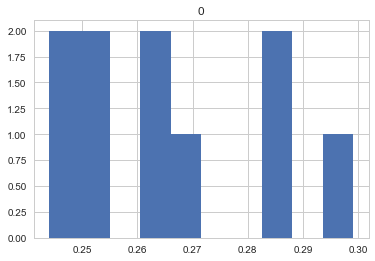

In [15]:
pd.DataFrame(scores).hist()
plt.show()

In [47]:
sgbm = GradientBoostingRegressor(random_state=666, **SGBM_KWARGS)
model = sgbm.fit(X, y, monitor=EarlyStopMonitor())

stopped after rounds: 509


In [48]:
model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=6, max_features=0.2,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=666, subsample=0.9, verbose=0,
             warm_start=False)

In [49]:
imp_df = pd.DataFrame({"gene": boruta_ex7_genes, "importance": model.feature_importances_})

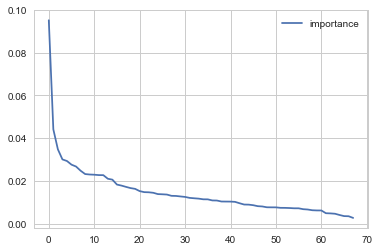

In [50]:
imp_df.sort_values(by='importance', ascending=False).plot(use_index=False)
plt.show()

In [51]:
important_features = imp_df.sort_values(by='importance', ascending=False)

In [52]:
important_features.head()

,gene,importance
20,Cst7,0.095181
64,Tyrobp,0.044128
22,Ctsd,0.034787
32,Gfap,0.030067
60,Sez6,0.029316


# Partial dependence plots

* https://github.com/nyuvis/partial_dependence
* https://www.youtube.com/watch?v=zqFj6l2WZCU
* See: https://github.com/SauceCat/PDPbox/blob/master/test/Regression/rossmann_df.ipynb
* Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation https://arxiv.org/pdf/1309.6392.pdf

In [33]:
from pdpbox import pdp
from pycebox import ice

In [34]:
ice_df = ice.ice(X, 'Apoe', sgbm.predict, num_grid_points=100)

In [39]:
gene = 'mt-Rnr1'
pdp_gene = pdp.pdp_isolate(sgbm, X, gene)
pdp.pdp_plot(pdp_gene, gene, center=False, plot_org_pts=True, plot_lines=True)

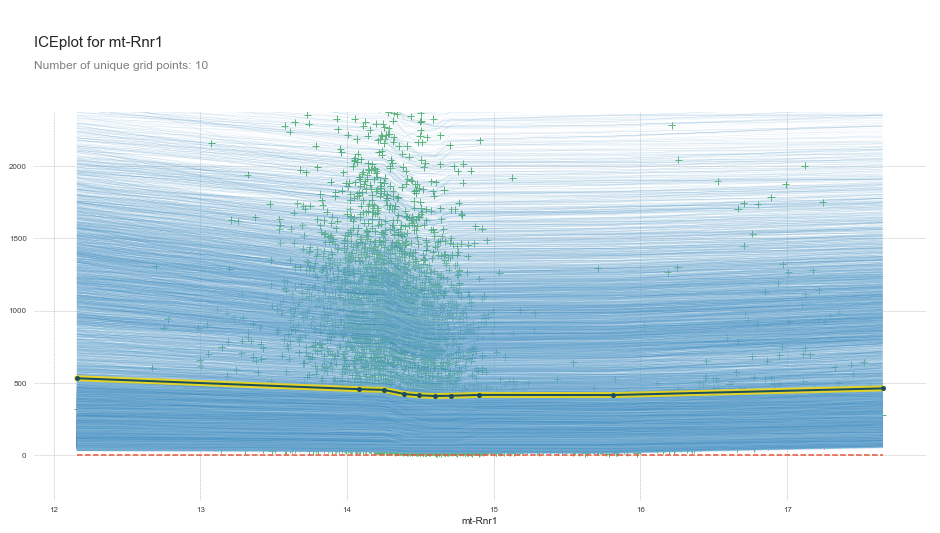

In [40]:
plt.show()

In [41]:
gene = 'mt-Rnr1'
pdp_gene = pdp.pdp_isolate(sgbm, X, gene)
pdp.pdp_plot(pdp_gene, gene, center=True, plot_org_pts=True, plot_lines=True)

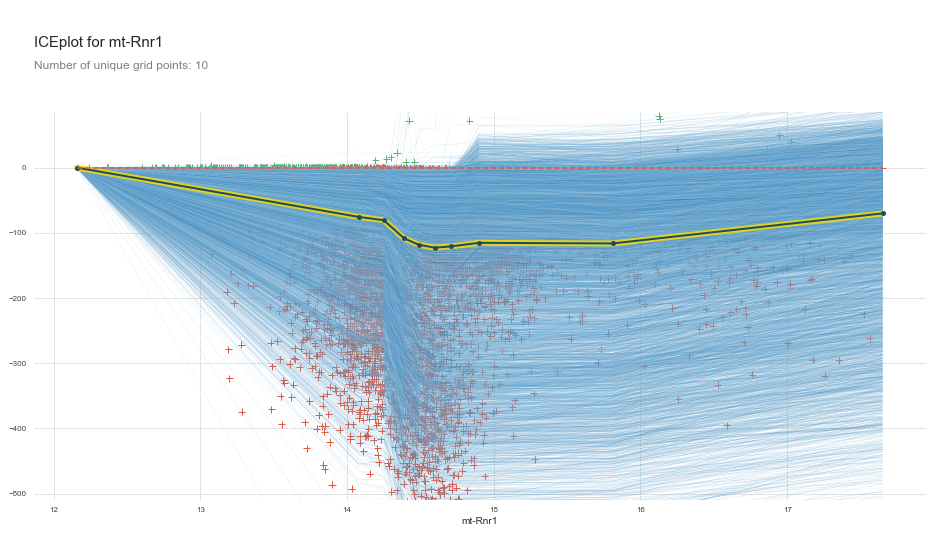

In [42]:
plt.show()

In [25]:
pdp_gene.pdp

array([455.53211303, 435.04138114, 431.67586729, 427.55125395,
       426.45842291, 424.28666571, 424.08856219, 424.64728398,
       427.62397489, 449.68531429])

In [26]:
pdp_gene.display_columns

array([ 2.98,  9.86, 10.18, 10.39, 10.55, 10.71, 10.88, 11.07, 11.33,
       13.02])

In [27]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence

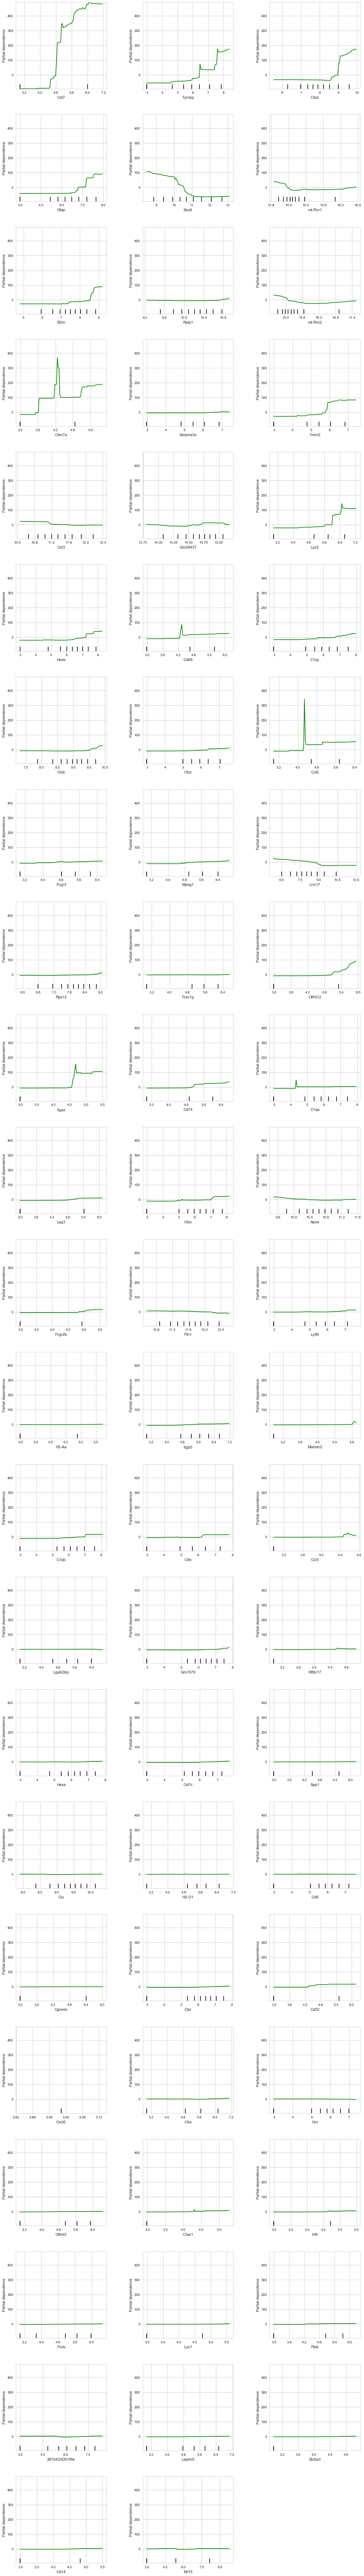

In [30]:
features_to_plot = list(important_features['gene'])
fig, axs = plot_partial_dependence(model, X, n_jobs=-1, 
                                   features=features_to_plot,
                                   feature_names=list(X.columns))

height = np.ceil(len(features_to_plot) / 3) * 8
fig.set_size_inches(16, height)

plt.show()

# Knock-In only



In [65]:
boruta_ex7_KI_genes = [
    'Apoe', 'B2m', 'C1qa', 'C1qb', 'C1qc', 'C4a', 'C4b', 'Ccl6', 'Cd52',
    'Cd68', 'Cd74', 'Clec7a', 'Clu', 'Csf1r', 'Cst3', 'Cst7', 'Ctsb',
    'Ctsd', 'Ctsl', 'Ctss', 'Ctsz', 'Fcer1g', 'Fcgr2b', 'Fcgr3', 'Fcrls',
    'Gfap', 'Gpnmb', 'Hexa', 'Hexb', 'Itgax', 'Lag3', 'Laptm5', 'Lpl',
    'Ly86', 'Lyz2', 'Mpeg1', 'Psap', 'Serpina3n', 'Trem2', 'Tyrobp',
    'mt-Rnr1', 'mt-Tf', 'mt-Tm']

In [71]:
set.difference(set(boruta_ex7_KI_genes), set(boruta_ex7_genes))

{'Lpl', 'Psap', 'mt-Tf', 'mt-Tm'}

In [81]:
set.difference(set(boruta_ex7_genes), set(boruta_ex7_KI_genes))

{'2810433D01Rik',
 'C3ar1',
 'Ccl3',
 'Cd14',
 'Cd9',
 'Cxcl5',
 'Fth1',
 'Gm28437',
 'Gm7079',
 'Grn',
 'H2-Aa',
 'H2-D1',
 'Irf8',
 'Itgb5',
 'Kif15',
 'Lgals3bp',
 'Lrrc17',
 'Lyz1',
 'Mamdc2',
 'Olfml3',
 'Olfr912',
 'Plek',
 'Rplp1',
 'Rps12',
 'Sez6',
 'Slc6a3',
 'Spp1',
 'Wfdc17',
 'mt-Rnr2'}

In [72]:
st_KI_df = st_df[st_df.GT == 'KI']

X_KI = st_KI_df[boruta_ex7_KI_genes]
y_KI = st_KI_df['AB1_StdDev_Yen']

In [73]:
sgbm_KI = GradientBoostingRegressor(random_state=666, **SGBM_KWARGS)
sgbm_KI.fit(X_KI, y_KI, monitor=EarlyStopMonitor())

stopped after rounds: 403


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=6, max_features=0.2,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=666, subsample=0.9, verbose=0,
             warm_start=False)

In [76]:
KI_imp_df = pd.DataFrame({"gene": boruta_ex7_KI_genes, "importance": sgbm_KI.feature_importances_})

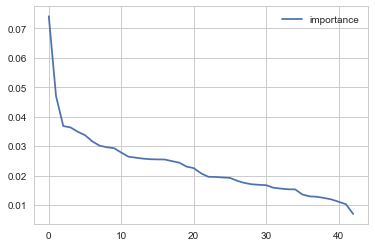

In [77]:
KI_imp_df.sort_values(by='importance', ascending=False).plot(use_index=False)
plt.show()

In [78]:
KI_important_features = KI_imp_df.sort_values(by='importance', ascending=False)

In [80]:
KI_important_features

,gene,importance
15,Cst7,0.074095
39,Tyrobp,0.046964
1,B2m,0.036820
25,Gfap,0.036343
17,Ctsd,0.034876
40,mt-Rnr1,0.033713
14,Cst3,0.031624
37,Serpina3n,0.030165
28,Hexb,0.029631
4,C1qc,0.029310


In [90]:
cross_val_score?

Signature: cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
Docstring:
Evaluate a score by cross-validation

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
estimator : estimator object implementing 'fit'
    The object to use to fit the data.

X : array-like
    The data to fit. Can be, for example a list, or an array at least 2d.

y : array-like, optional, default: None
    The target variable to try to predict in the case of
    supervised learning.

groups : array-like, with shape (n_samples,), optional
    Group labels for the samples used while splitting the dataset into
    train/test set.

scoring : string, callable or None, optional, default: None
    A string (see model evaluation documentation) or
    a scorer callable object / function with signature
    ``scorer(estimator, X, y)``.

cv : int, cross-validation generator or an iterable, optional
    Determine